# Quantum Repeater Design

## Heralded Quantum Repeater

### Components

* QGen - perform entangled photons/qubits generation
* QSwap - performing quantum entanglement swapping
* Alice - represents sender
* Bob - represents destination/recipient
* QMem - stores qubits awaiting swapping protocol

In [205]:
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import transpile
from qiskit.result import Counts, marginal_counts
from qiskit.visualization import array_to_latex, plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector, Statevector, state_fidelity
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit.circuit.library import RXGate

In [206]:
class QuantumCircuitOperations:
    def __init__(self, barrier: bool = False):
        self.barrier = barrier
    
    def create_random_statevector(self, dimensions: int) -> Statevector:
        return random_statevector(dimensions)
    
    def create_bell_pairs(self, qc: QuantumCircuit, regs: list) -> None:
        if self.barrier: qc.barrier()
        for reg in regs:
            for q in range(reg.size):
                if q % 2 == 0:
                    qc.h(reg[q])
                    qc.cx(reg[q], reg[q + 1])
    
    def bell_state_operation(self, qc: QuantumCircuit, a: QuantumRegister) -> None:
        if self.barrier: qc.barrier()
        qc.cx(a[0], a[1])
        qc.h(a[0])
    
    def bell_state_measurement(self, qc: QuantumCircuit, a: QuantumRegister) -> None:
        if self.barrier: qc.barrier()
        qc.measure(a[0], 0)
        qc.measure(a[1], 1)
    
    def pauli_correction_operation(self, qc: QuantumCircuit, b: QuantumRegister, bsm_z: ClassicalRegister, bsm_x: ClassicalRegister) -> None:
        # Apply the gates if the registers are in the state '1'
        if self.barrier: qc.barrier()
        qc.x(b).c_if(bsm_x, 1)
        qc.z(b).c_if(bsm_z, 1)

In [207]:
class QuantumVisualizations:
    def display_statevector_as_array(self, psi: Statevector) -> None:
        display(array_to_latex(psi, prefix="|\\psi\\rangle = "))
    
    def display_bloch_statevector(self, psi: Statevector):
        return plot_bloch_multivector(psi)

In [208]:
class QuantumNativeSimulations:
    def statevector_sim(self, qc: QuantumCircuit) -> Statevector:
        # returns the circuit statevector
        state_sim: StatevectorSimulator = StatevectorSimulator()
        return state_sim.run(transpile(qc, state_sim)).result().get_statevector()
    
    def qasm_sim(self, qc: QuantumCircuit) -> Counts:
        qasm_sim: QasmSimulator = QasmSimulator()
        return qasm_sim.run(transpile(qc, qasm_sim), shots=10240).result().get_counts()

In [209]:
qgen_alice: QuantumRegister = QuantumRegister(2, "qgen_alice")
qgen_bob: QuantumRegister = QuantumRegister(2, "qgen_bob")

swap_channel: QuantumRegister = QuantumRegister(2, "swap_channel")

qmem: QuantumRegister = QuantumRegister(2, "qmem")

alice: QuantumRegister = QuantumRegister(1, "alice")
bob: QuantumRegister = QuantumRegister(1, "bob")

bsm_z: ClassicalRegister = ClassicalRegister(1, "bsm_zresult")
bsm_x: ClassicalRegister = ClassicalRegister(1, "bsm_xresult")

coz: ClassicalRegister = ClassicalRegister(1, "coz")
cox: ClassicalRegister = ClassicalRegister(1, "cox")

qc: QuantumCircuit = QuantumCircuit(qgen_alice, qgen_bob, qmem, alice, bob, swap_channel, bsm_z, bsm_x, coz, cox)

In [210]:
qco: QuantumCircuitOperations = QuantumCircuitOperations(True)
qns: QuantumNativeSimulations = QuantumNativeSimulations()

In [211]:
qco.create_bell_pairs(qc, [qgen_alice, qgen_bob])

In [212]:
qc.barrier()
qc.swap(qgen_alice[0], qmem[0])
qc.swap(qgen_alice[1], alice)
qc.swap(qgen_bob[0], qmem[1])
qc.swap(qgen_bob[1], bob)

In [213]:
qc.barrier()
qc.swap(qmem[0], swap_channel[0])
qc.swap(qmem[1], swap_channel[1])

In [214]:
qco.bell_state_operation(qc, swap_channel)

In [215]:
qco.bell_state_measurement(qc, swap_channel)

In [216]:
qco.pauli_correction_operation(qc, bob, bsm_z, bsm_x)

In [217]:
qc.barrier()
qc.cx(alice, bob)
qc.h(alice)

In [218]:
qc.barrier()
qc.measure(alice, coz)
qc.measure(bob, cox)

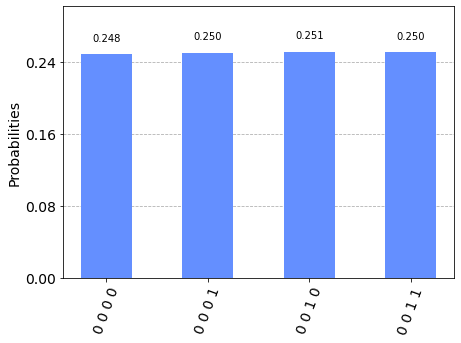

In [219]:
counts: Counts = qns.qasm_sim(qc)
plot_histogram(counts)

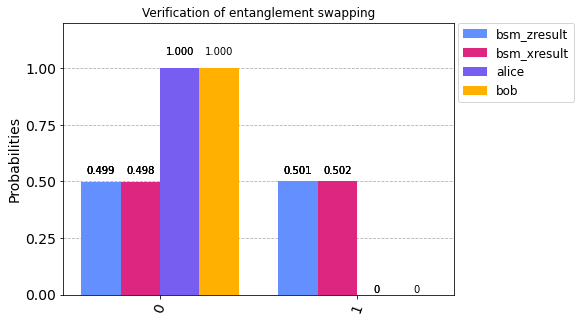

In [220]:
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(4)]
legend: list = ["bsm_zresult", "bsm_xresult", "alice", "bob"]
plot_histogram(qubit_counts, legend=legend, title="Verification of entanglement swapping")

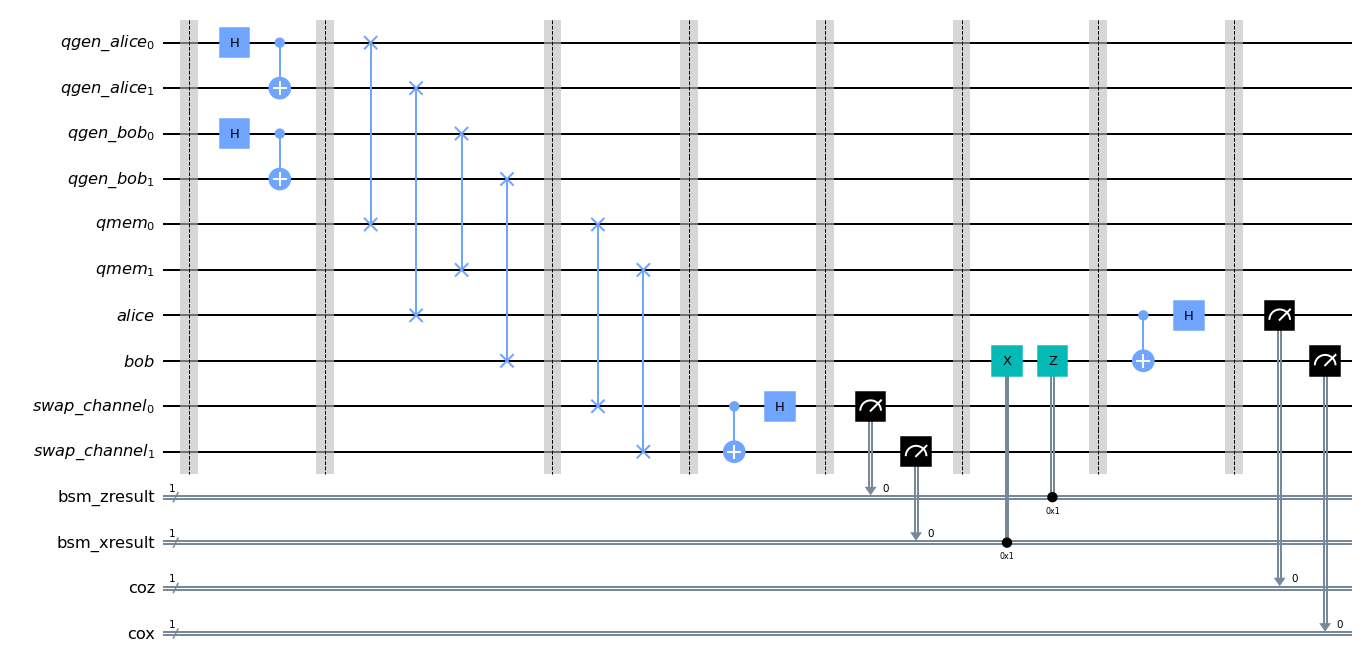

In [221]:
qc.draw("mpl", fold=-1)